# Домашнее задание 7

(прислать до 02:00 30.10.2018)

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне в Piazza через Private Post.
Файл с Вашим решением должен называться ```Surname_HW#```, где вместо ```Surname``` Вы пишите свою фамилию латиницей, а вместо ```#``` - номер домашнего задания. 
Решение каждой задачи необходимо поместить после её условия.

Пожалуйста, пишите свои решения чётко и понятно. 
При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 
Если возникает ошибка, то я сообщаю Вам об этом и жду исправленного решения, которое будет удовлетворять указанному требованию.

In [67]:
import numpy as np
import liboptpy.base_optimizer as base
import liboptpy.unconstr_solvers.fo as fo
import liboptpy.step_size as ss
import liboptpy.restarts as restarts
import scipy.linalg as linalg
import scipy.stats as sps
import scipy.optimize as spo
from scipy.sparse.linalg import cg
import seaborn as sns
from matplotlib import pyplot as plt

%autosave 15

Autosaving every 15 seconds


## Задача 1

Проверьте, что направления в методе сопряжённых градиентов для квадратичной целевой функции и в методе Флетчера-Ривса являются направлениями убывания. Для любой ли стратегии линейного поиска шага в методе Флетчера-Ривса полученное направление будет направлением убывания? Почему?

Даёт ли процедура дробления шага шаг, удовлестворябщий условию Вольфа? Если нет, то почему и как её нужно модифицировать, чтобы найти шаг, удовлетворяющий условию Вольфа?

In [122]:
# См. прикреплённый .tex-файл!

## Задача 2

Покажите, что сопряжённые направления являются линейно независимыми

Направления $ \{p_{i}\}_{i=1}^{n} $, сопряжённые относительно $ A \in S^{n}_{++} $ определяются соотношениями $ p_{i} A p_{j} = 0 \iff  i \neq j $. Геометрически это означает, что они ортогональны в метрическом пространстве, для которого $A$ — матрица Грама. Говорят, что такие направления *$ A $-ортогональны*. Покажем, что из *$ A $-ортогональности* следует линейная независимость.  
Предположим противное: 
$$ (1)\ \exists \lambda_{1}, \ldots, \lambda_{n}: \sum_{i=1}^{n} \lambda_{i}^{2} \neq 0, \sum_{i=1}^{n} \lambda_{i} p_{i} = 0 $$
Будем последовательно домножать (1) слева на $ p_{j}^{\top} A $.  
\begin{align*}
    &p_{j}^{\top} A \sum_{i=1}^{n} \lambda_{i} p_{i} = 0\\
    &\lambda_{j} p_{j}^{\top} A p_{j} = 0\\
    &\lambda_{j} = 0
\end{align*}
Отсюда выводим противоречие с $ \sum_{i=1}^{n} \lambda_{i}^{2} \neq 0 $. 

## Задача 3

Исследуйте зависимость числа итераций необходимого для сходимости линейного метода сопряжённых градиентов от распределения собственных значений матрицы $A$. 
Рассмотрите следуюшие сценарии
- собственные значения распределены равномерно на некотором отрезке
- собственные числа распределены блоками около некоторых заданных чисел в окрестности радиуса $\varepsilon$, например каждые 5 собственных значений находятся в окрестности радиуса $0.5$ около чисел кратных 5. Придумайте свою стратегию генерации матриц по заданному сценарию

Постройте соответствующий график для каждого сценария. Если сценарий зависит от параметра, то на одном графике изобразите зависимость для нескольких наиболее характерных параметров, добавьте легенду.

In [32]:
def clustered_eigvals(dim, step, cluster_size, cluster_width):
    # Eigenvalues get distributed uniformly over clusters
    n_clusters = np.ceil(dim / cluster_size).astype(np.int32)
    centers = step * (np.arange(n_clusters) + 1)
    clusters = sps.uniform(
        loc=centers - cluster_width, 
        scale=np.full(n_clusters, 2 * cluster_width)
    ).rvs(size=(cluster_size, n_clusters)).T
    return np.ravel(clusters)[:dim]

def matrix_from_eigvals(eigvals):
    n = eigvals.size
    U = linalg.orth(np.random.rand(n, n))
    resh = U.T @ np.diag(eigvals) @ U
#     In case of paranoia
#     assert np.allclose(res, res.T)
#     assert np.all(linalg.eigvalsh(res) > 0)
#     assert np.allclose(sorted(linalg.eigvalsh(res)), sorted(eigvals))
    return resh

### 3.1. Собственные значения распределены равномерно

In [33]:
iter_count = 0
def callback(x):
    global iter_count
    iter_count += 1

In [34]:
n = 100
iter_logs = []
thetas = np.linspace(1, 1000, 100)
for theta in thetas:
    A = matrix_from_eigvals(sps.uniform(0, theta).rvs(n))
    b = np.random.rand(n)
    iter_count = 0
    x = cg(A, b, callback=callback)
    iter_logs.append(iter_count)

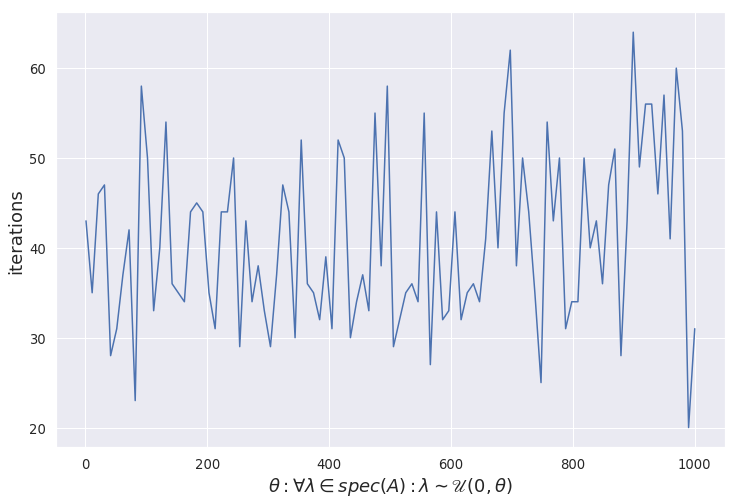

In [35]:
plt.figure(figsize=(12, 8))
sns.lineplot(thetas, iter_logs)
sns.set(font_scale=1.2)
plt.xlabel(r'$\theta: \forall \lambda \in spec(A): \lambda \sim \mathscr{U}(0, \theta$)', fontsize=18)
plt.ylabel('iterations', fontsize=18);

Видим, что скорость сходимости отвратительная.  
Попробуем сгенерировать кластеры. Видно, что с ростом их размера (и уменьшением их количества) скорость сходимости улучшается.

In [41]:
n = 100
iter_logs = []
cluster_sizes = np.arange(n) + 1
for cluster_size in cluster_sizes:
    A = matrix_from_eigvals(
        clustered_eigvals(
            dim=n, step=cluster_size, 
            cluster_size=cluster_size,
            cluster_width=0.5
        )
    )
    b = np.random.rand(n)
    iter_count = 0
    x = cg(A, b, callback=callback)
    iter_logs.append(iter_count)

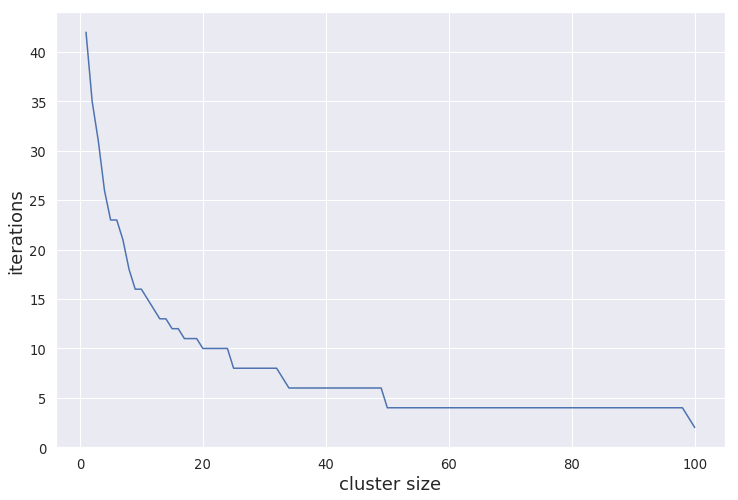

In [42]:
plt.figure(figsize=(12, 8))
sns.lineplot(cluster_sizes, iter_logs)
plt.xlabel('cluster size', fontsize=18);
plt.ylabel('iterations', fontsize=18);

### 3.2. Спектр кластеризован
Если количество кластеров — k, то они идут с шагом в k с центрами в точках $k \cdot i,\ i \ge 1$.  
Радиус $\varepsilon$ кластеров при этом задаётся вручную и принимает значения в $ (0, k) $.  

In [44]:
n = 300
cluster_sizes = [5, 10, 15, 20, 50, 100]
cluster_widths = np.linspace(1e-3, 5, 100)

Посмотрим для начала, как изменится взаимное расположение кластеров, если варьировать радиус.

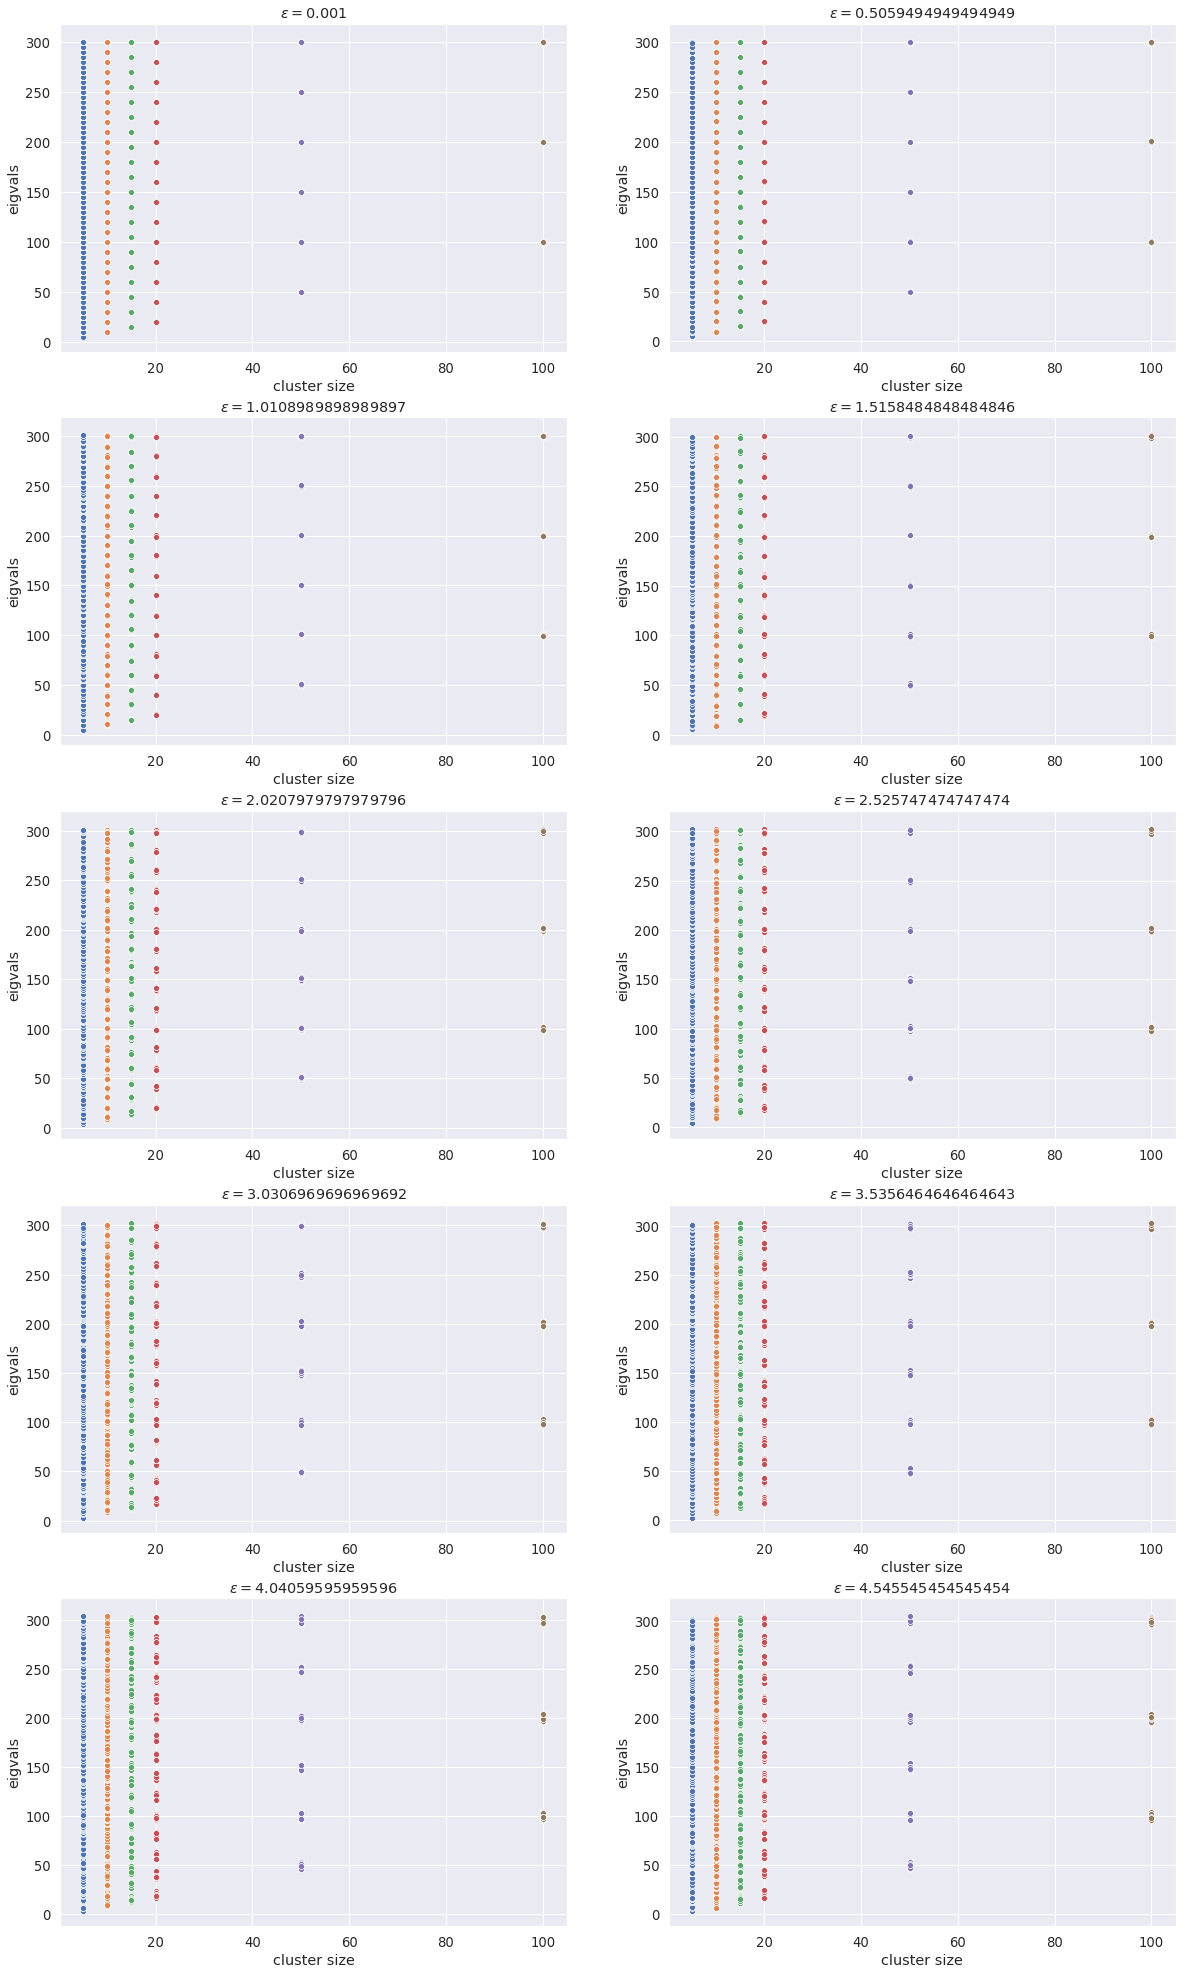

In [39]:
plt.figure(figsize=(20, 35))
for i, cluster_width in enumerate(cluster_widths[::10]):
    plt.subplot(5, 2, i + 1)
    for j, cluster_size in enumerate(cluster_sizes):
        sns.scatterplot(
            np.ones(n) * cluster_size,
            clustered_eigvals(
                dim=n, step=cluster_size, 
                cluster_size=cluster_size, 
                cluster_width=cluster_width
            )
        )
    plt.title(r'$\epsilon = {}$'.format(cluster_width))
    plt.ylabel("eigvals")
    plt.xlabel("cluster size")

Видно, что с ростом радиуса кластеры всё сильнее "наползают" друг на друга, а в пределе общая картина и вовсе мало отличается от равномерного распределения. Теория говорит, что скорость сходимости должна ухудшаться с ростом радиуса кластера. Эксперимент показывает, что это действительно так.  
Изначально центр первого кластера находился в точке $\varepsilon$. Это оказалось чревато большими проблемами в интерпретации результатов: дело в том, что при маленьких $\varepsilon$ число обусловленности задачи оказывалось просто огромным (порядка $10^4 - 10^5$). Скорость сходимости от этого сильно падала. С ростом радиуса кластеров число итераций до сходимости, вопреки теории и здравому смыслу, уменьшалось. Как позднее выяснилось, это происходило за счёт того, что первый кластер отдалялся от нуля, из-за чего число обусловленности резко падало и это компенсировало негативный эффект от ухудшения кластеризации. История вышла поучительной. Для того, чтобы проиллюстрировать зависимость скорости сходимости от степени кластеризации, я в итоге просто отдалился от нуля на достаточное расстояние. Зависимость сразу стала совпадать с теоретически предсказанной.

CPU times: user 4min 26s, sys: 14.5 s, total: 4min 41s
Wall time: 17.6 s


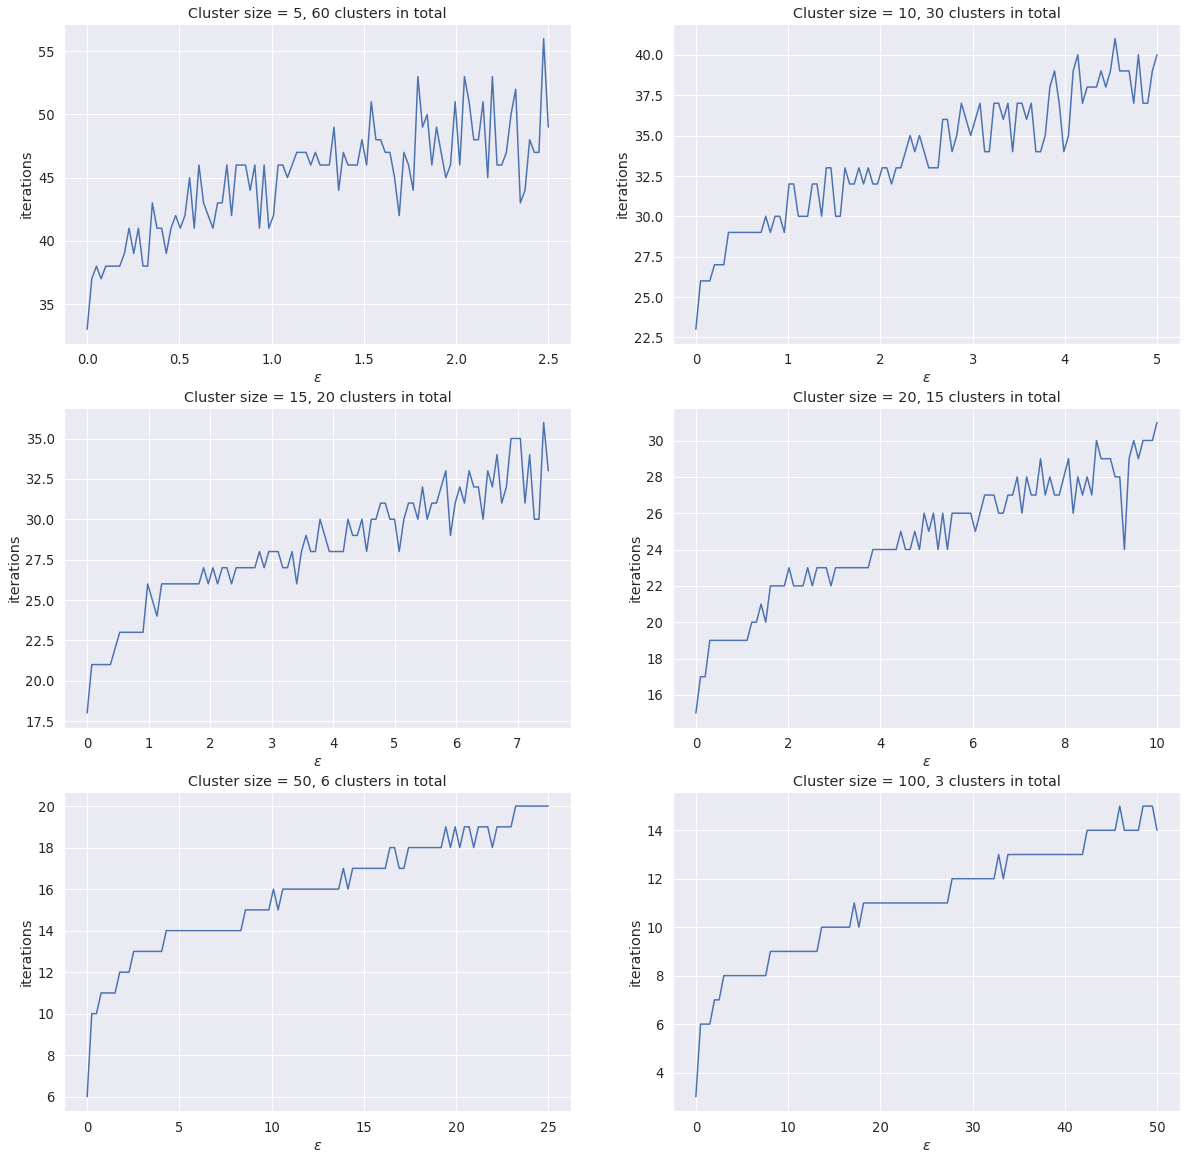

In [45]:
%%time
plt.figure(figsize=(20, 20))
for i, cluster_size in enumerate(cluster_sizes):
    plt.subplot(3, 2, i + 1)
    iterations_info = []
    b = np.random.rand(n)
    cluster_widths = np.linspace(0.0001, cluster_size/2, 100)
    for eps in cluster_widths:
        A = matrix_from_eigvals(clustered_eigvals(dim=n, step=cluster_size,
                                      cluster_size=cluster_size, cluster_width=eps))
        iter_count = 0
        x = cg(A, b, callback=callback)
        iterations_info.append(iter_count)
    sns.lineplot(cluster_widths, iterations_info)
    plt.title('Cluster size = {}, {} clusters in total'.format(
        cluster_size, np.ceil(n / cluster_size).astype(np.int32)
    ))
    plt.xlabel(r'$\epsilon$')
    plt.ylabel('iterations')

## Задача 4

Сравните экспериментально скорость сходимости метода Флетчера-Ривса, тяжёлого шарика и ускоренного метода Нестерова при миминимизации функции Розенброка для $n = 10, 50, 100$. Попробуйте разные стратегии выбора параметров для метода тяжёлого шарика и ускоренного метода Нестерова. Объясните полученные результаты

In [4]:
class HeavyBall(base.LineSearchOptimizer):
    def __init__(self, f, grad, step_size, beta, **kwargs):
        super().__init__(f, grad, step_size, **kwargs)
        self._beta = beta
    
    def get_direction(self, x):
        self._current_grad = self._grad(x)
        return -self._current_grad

    def _f_update_x_next(self, x, alpha, h):
        if len(self.convergence) < 2:
            return x + alpha * h
        else:
            return x + alpha * h + self._beta * (x - self.convergence[-2])
    
    def get_stepsize(self):
        return self._step_size.get_stepsize(self._grad_mem[-1], self.convergence[-1], len(self.convergence))

In [87]:
f = lambda x: spo.rosen(x)
gradf = lambda x: spo.rosen_der(x)
n_list = [10, 50, 100]
max_iter = 4e4
tol = 1e-6

In [117]:
methods_FR = {
    "FR, α = 0.001": fo.ConjugateGradientFR(f, gradf, ss.ConstantStepSize(0.001)),
    "FR_restarts, α = 0.001": fo.ConjugateGradientFR(f, gradf, ss.ConstantStepSize(0.001), restarts.Restart(30)),
    "FR_Armijo": fo.ConjugateGradientFR(
            f, gradf, ss.Backtracking("Armijo", rho=0.3, beta=0.1, init_alpha=0.01)
    ),
    "FR_Wolfe": fo.ConjugateGradientFR(
        f, gradf, ss.Backtracking("Wolfe", beta1=0.1, beta2=0.4, rho=0.5, init_alpha=1.)),
    "FR_Wolfe_Restarts": fo.ConjugateGradientFR(
        f, gradf, ss.Backtracking("Wolfe", beta1=0.1, beta2=0.4, rho=0.5, init_alpha=1.), 
        restarts.Restart(30)
    ),
}
methods_HB = {
    "HB, α = 5e-4": HeavyBall(f, gradf, beta=0.9, step_size=ss.ConstantStepSize(0.0005)),
    "HB_Armijo": HeavyBall(f, gradf, ss.Backtracking("Armijo", rho=0.3, beta=0.1, init_alpha=0.01), beta=0.9),
    "HB_Wolfe": HeavyBall(
        f, gradf,  ss.Backtracking("Wolfe", beta1=0.1, beta2=0.4, rho=0.5, init_alpha=1.), beta=0.9
    )
}
methods_Nesterov = {
    "Nesterov_Armijo": fo.AcceleratedGD(
        f, gradf, ss.Backtracking("Armijo", rho=0.3, beta=0.1, init_alpha=0.01)
    ),
    "Nesterov_Wolfe": fo.AcceleratedGD(
        f, gradf, ss.Backtracking("Wolfe", beta1=0.1, beta2=0.4, rho=0.5, init_alpha=1.)
    )
}
methods = {
    "FR" : methods_FR,
    "HB" : methods_HB,
    "Nesterov" : methods_Nesterov
}

In [118]:
def plot_convergence(f, gradf, methods, n_list, max_iter, tol):
    for n in n_list:
        print("__________________________")
        x0 = x0 = sps.uniform(0.001, 0.01).rvs(n)
        for m in methods.keys():
            print("Method: {}".format(m))
            _ = methods[m].solve(x0=x0, max_iter=max_iter, tol=tol, disp=True)
        print("__________________________")
        figsize = (14, 10)
        fontsize = 20
        plt.figure(figsize=figsize)
        sns.set_style("whitegrid")
        for m in methods:
            plt.semilogy([np.linalg.norm(gradf(x)) for x in methods[m].get_convergence()], label=m)
        plt.title("Dimension: {}".format(n), fontsize=fontsize)
        plt.legend(fontsize=fontsize, loc="best")
        plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
        plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        _ = plt.yticks(fontsize=fontsize)
        plt.show()

__________________________
Method: FR_restarts, α = 0.001
Maximum iteration exceeds!
Convergence in 6000 iterations
Function value = 3.242111477012056e-05
Norm of gradient = 0.005710896043057696
Method: FR_Armijo
Convergence in 3229 iterations
Function value = 6.730380759320548e-13
Norm of gradient = 8.974157274180431e-07
Method: FR_Wolfe_Restarts
Convergence in 2671 iterations
Function value = 3.662250579354617e-13
Norm of gradient = 9.352552887719778e-07
Method: FR, α = 0.001
Maximum iteration exceeds!
Convergence in 6000 iterations
Function value = 3.0401226496551714e-05
Norm of gradient = 0.005529396882192326
Method: FR_Wolfe
Convergence in 2637 iterations
Function value = 3.3314952964122315e-13
Norm of gradient = 9.429580372349837e-07
__________________________


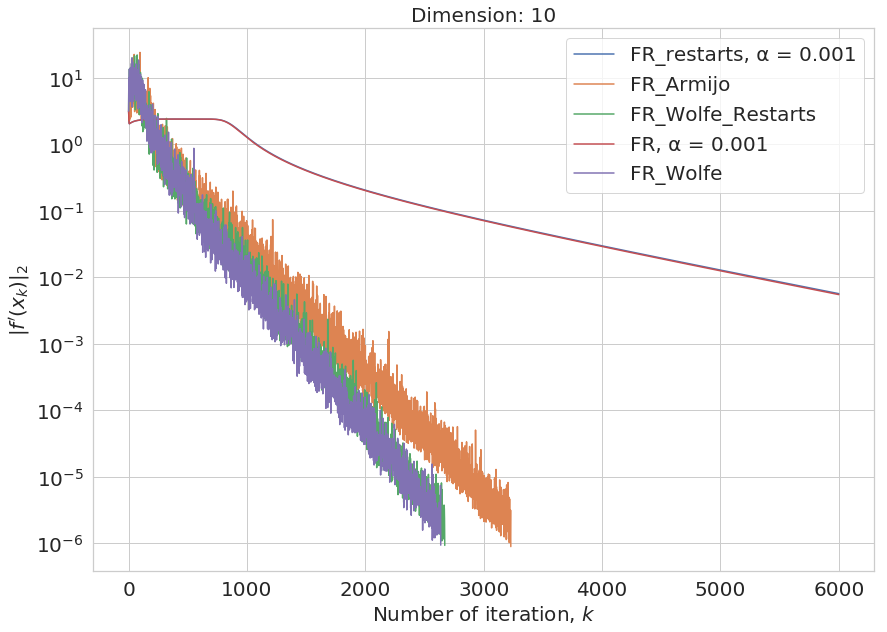

__________________________
Method: FR_restarts, α = 0.001
Maximum iteration exceeds!
Convergence in 6000 iterations
Function value = 0.05398309514601025
Norm of gradient = 0.27713022565071865
Method: FR_Armijo
Convergence in 4309 iterations
Function value = 7.892988602477132e-13
Norm of gradient = 9.93552492553356e-07
Method: FR_Wolfe_Restarts
Convergence in 3470 iterations
Function value = 2.9353901526175555e-13
Norm of gradient = 7.472496227090271e-07
Method: FR, α = 0.001
Maximum iteration exceeds!
Convergence in 6000 iterations
Function value = 0.04932435001429433
Norm of gradient = 0.2627909542291239
Method: FR_Wolfe
Convergence in 3407 iterations
Function value = 4.111116317889919e-13
Norm of gradient = 9.503151935929502e-07
__________________________


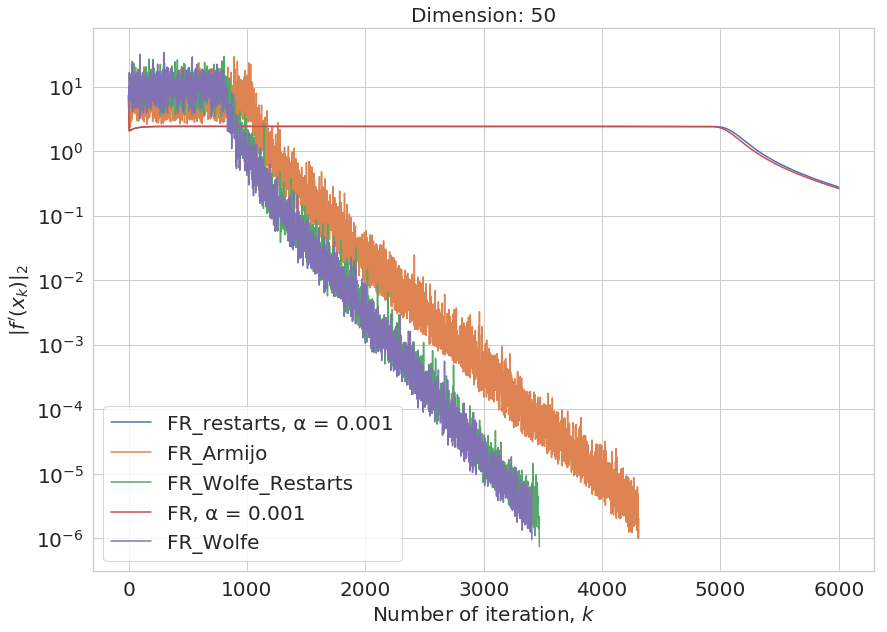

__________________________
Method: FR_restarts, α = 0.001
Maximum iteration exceeds!
Convergence in 6000 iterations
Function value = 42.08636163693089
Norm of gradient = 2.4119833092595733
Method: FR_Armijo
Convergence in 5407 iterations
Function value = 7.270306357824435e-13
Norm of gradient = 9.605717756051355e-07
Method: FR_Wolfe_Restarts
Convergence in 4483 iterations
Function value = 2.3711093905291045e-13
Norm of gradient = 8.318375493458903e-07
Method: FR, α = 0.001
Maximum iteration exceeds!
Convergence in 6000 iterations
Function value = 41.714373474501215
Norm of gradient = 2.4121032583628907
Method: FR_Wolfe
Convergence in 4419 iterations
Function value = 3.7137942178659457e-13
Norm of gradient = 9.71549806388958e-07
__________________________


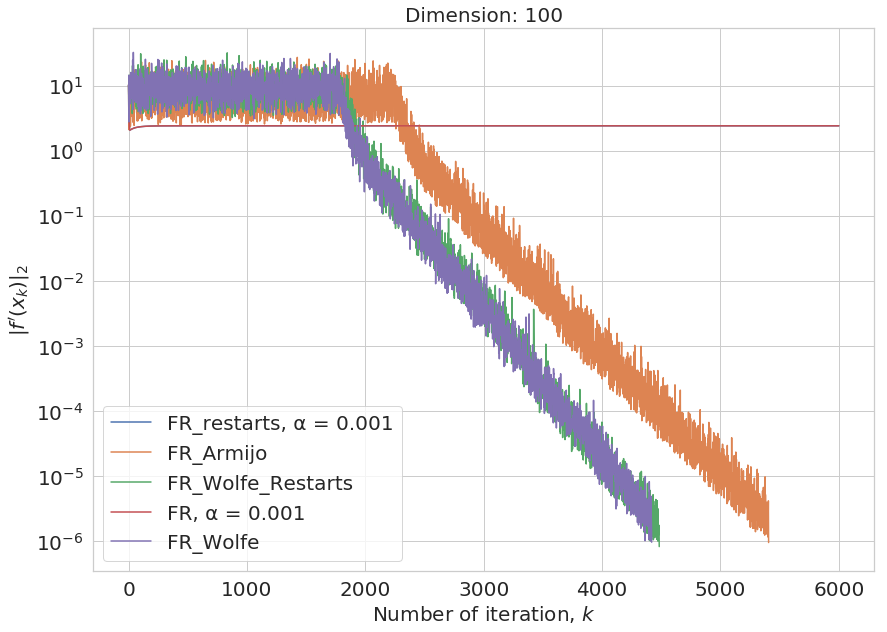

CPU times: user 24.8 s, sys: 194 ms, total: 25 s
Wall time: 24.8 s


In [119]:
%%time
max_iter = 6e3
plot_convergence(f, gradf, methods["FR"], n_list, max_iter, tol)

__________________________
Method: HB_Armijo
Convergence in 2647 iterations
Function value = 1.7238398035087938e-13
Norm of gradient = 7.983755277126768e-07
Method: HB_Wolfe
Convergence in 6819 iterations
Function value = 5.856425171682449e-13
Norm of gradient = 9.448426949266033e-07
Method: HB, α = 5e-4
Convergence in 5261 iterations
Function value = 1.0023891751330618e-12
Norm of gradient = 9.999440946786854e-07
__________________________


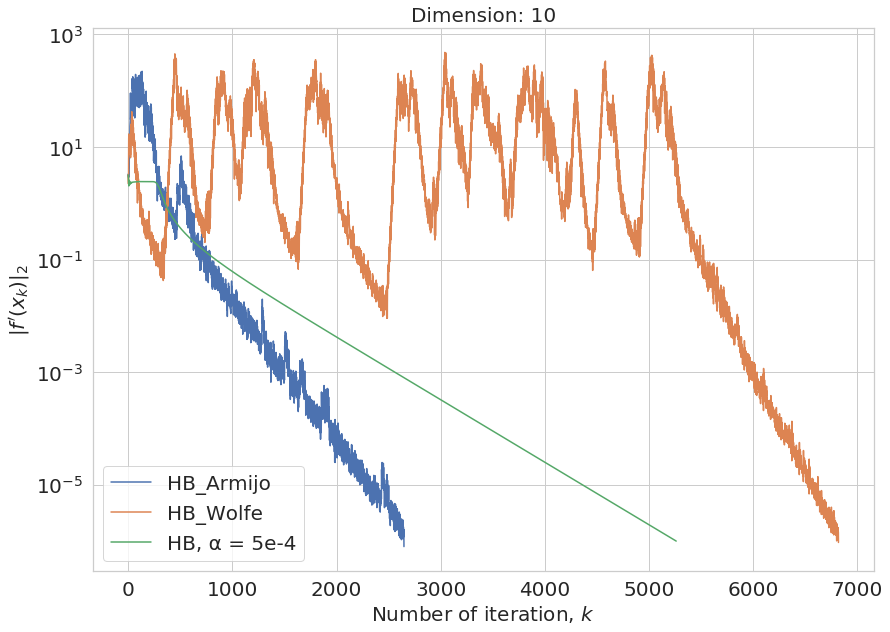

__________________________
Method: HB_Armijo
Convergence in 3062 iterations
Function value = 2.664719804406356e-13
Norm of gradient = 9.806428783852904e-07
Method: HB_Wolfe
Maximum iteration exceeds!
Convergence in 100000 iterations
Function value = 5.39144976109592
Norm of gradient = 98.57555939541558
Method: HB, α = 5e-4
Convergence in 6630 iterations
Function value = 9.983571181727246e-13
Norm of gradient = 9.979323240530467e-07
__________________________


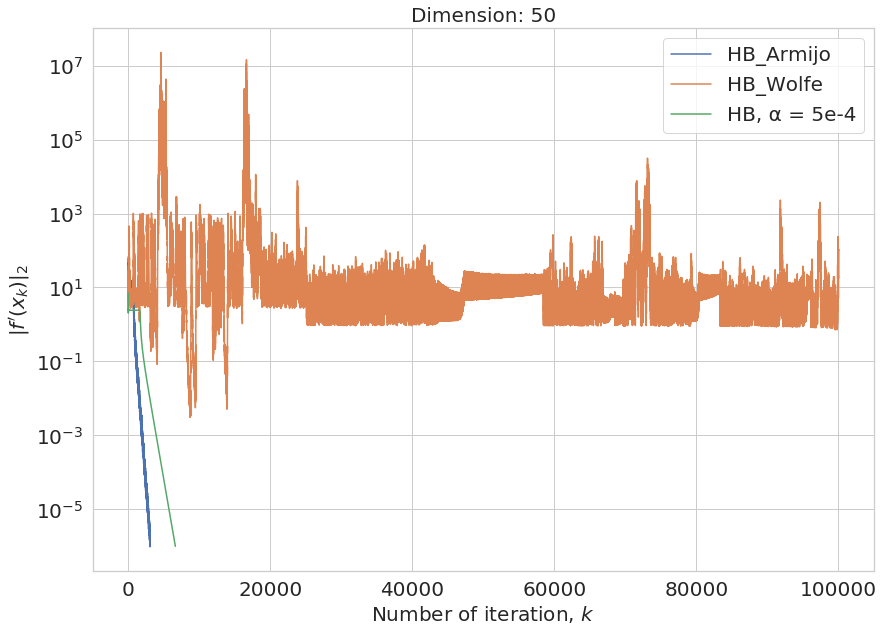

__________________________
Method: HB_Armijo
Convergence in 3918 iterations
Function value = 1.6685844455084782e-13
Norm of gradient = 9.95355030337664e-07
Method: HB_Wolfe
Maximum iteration exceeds!
Convergence in 100000 iterations
Function value = 80.83415688307613
Norm of gradient = 5.617862207089735
Method: HB, α = 5e-4
Convergence in 8339 iterations
Function value = 1.0015825861842046e-12
Norm of gradient = 9.995430731027978e-07
__________________________


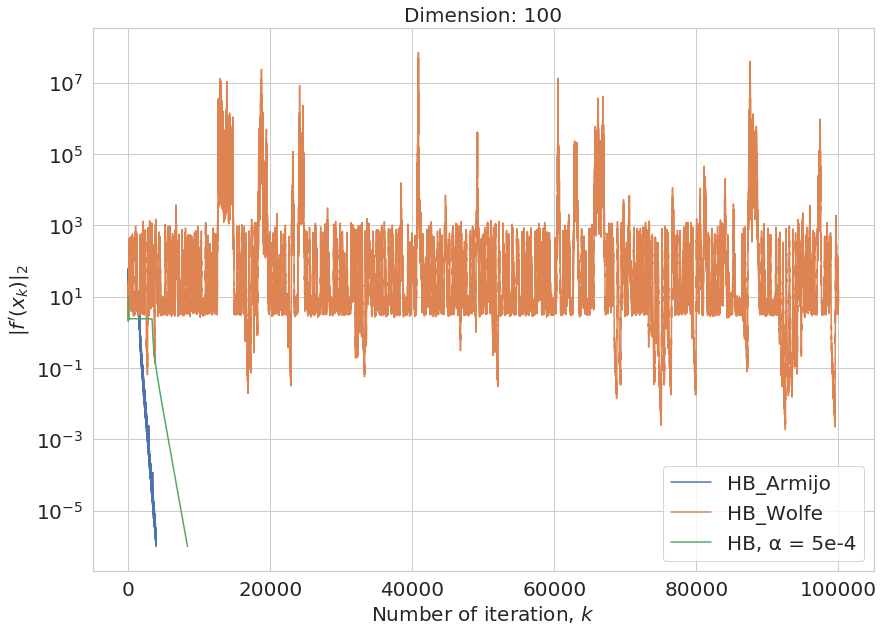

CPU times: user 3min 19s, sys: 2.2 s, total: 3min 21s
Wall time: 3min 1s


In [120]:
%%time
max_iter = 1e5
plot_convergence(f, gradf, methods["HB"], n_list, max_iter, tol)

__________________________
Method: Nesterov_Armijo
Maximum iteration exceeds!
Convergence in 100000 iterations
Function value = 2472438163071.489
Norm of gradient = 17970893033.90734
Method: Nesterov_Wolfe
Convergence in 2759 iterations
Function value = 7.750943789198136e-13
Norm of gradient = 2.7687755012768456e-05
__________________________


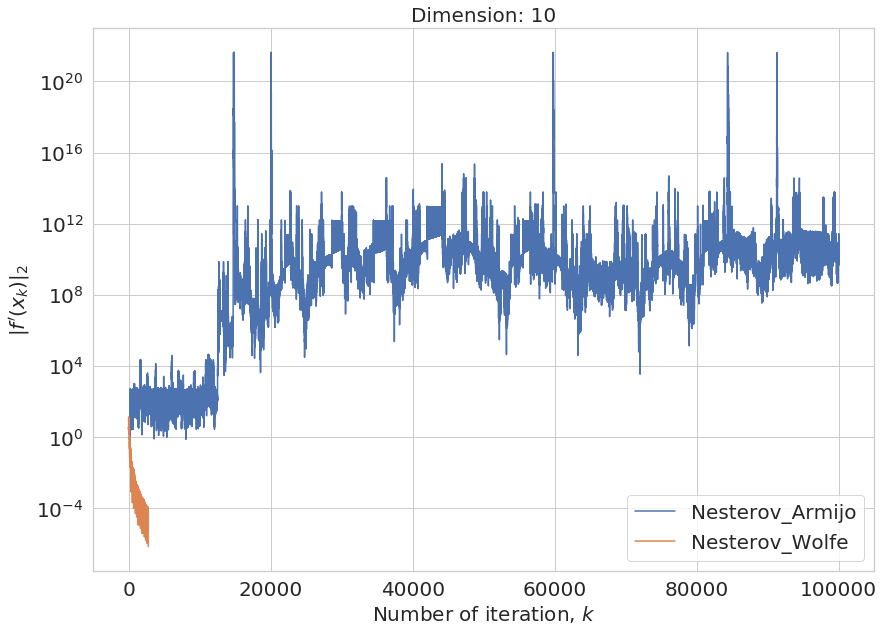

__________________________
Method: Nesterov_Armijo
Maximum iteration exceeds!
Convergence in 100000 iterations
Function value = 163.86045865364346
Norm of gradient = 241.21454661081123
Method: Nesterov_Wolfe
Convergence in 13715 iterations
Function value = 1.0706092578646679e-12
Norm of gradient = 3.47759963930579e-05
__________________________


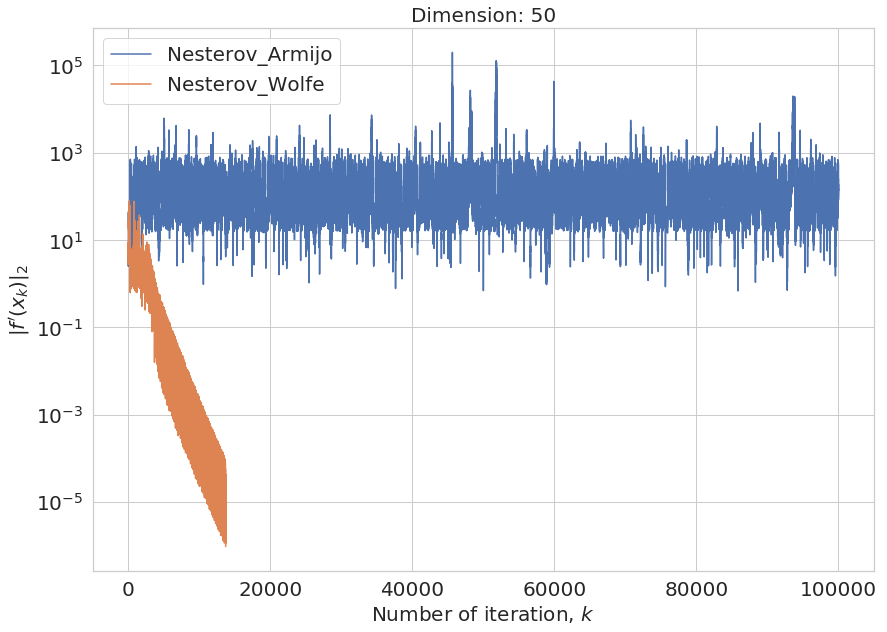

__________________________
Method: Nesterov_Armijo
Maximum iteration exceeds!
Convergence in 100000 iterations
Function value = 6.490867986341302e+16
Norm of gradient = 53384749780630.69
Method: Nesterov_Wolfe
Convergence in 16701 iterations
Function value = 7.956875317114656e-13
Norm of gradient = 3.4204575560073234e-05
__________________________


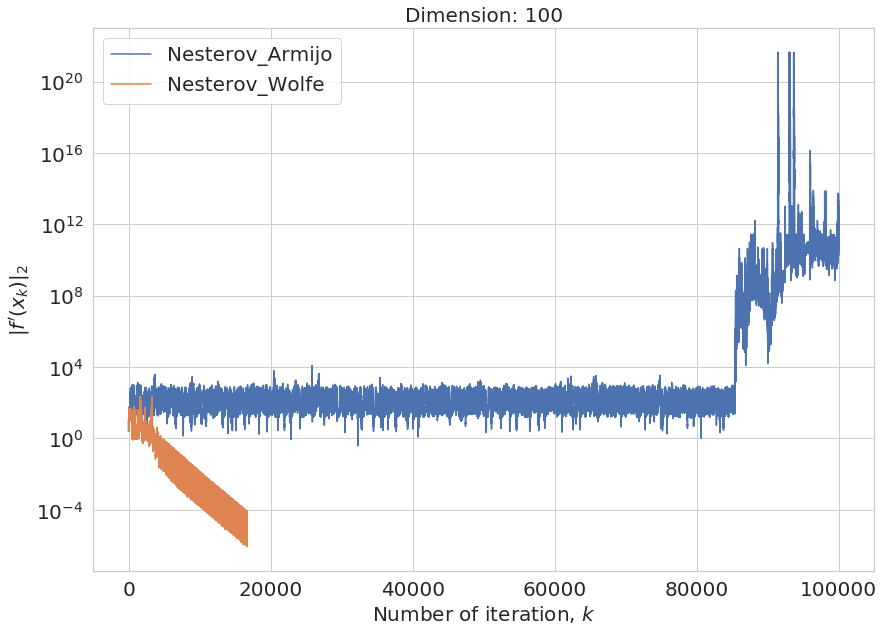

CPU times: user 3min 42s, sys: 3.93 s, total: 3min 46s
Wall time: 3min 16s


In [121]:
%%time
plot_convergence(f, gradf, methods["Nesterov"], n_list, max_iter, tol)

Признаться честно, сделать выводы по полученным результатам сложно. Эксперименты показали, что методы Нестерова и тяжёлого шарика сильно зависят от выбора констант в методах Армихо и Вольфа (скажем, у меня получалось поменять картину для Нестерова на противоположную). Если выбор неудачный, то методы вполне могут и расходиться (что видно для обоих алгоритмов).  
Тем не менее, обычный шарик с постоянным шагом на удивление упрямо показывает хорошую сходимость, а метод Армихо его даже опреежает. Причём, метод тяжёлого шарика сходится быстрее всех. Видно, что метод хороший, но с гиперпараметрами нужно угадать, как и с начальным приблжением.  
Для метода Нестерова выводы, в целом, аналогичны, но здесь уже нет той стабильности, которую демонстрирует метод тяжёлого мячика. Складывается впечатление, что "движение по инерции", которое имитирует этот метод, в случае функции Розенброка только мешает движению по узкой "ложбине". Из этих соображений становится более-менее ясно, почему метод Вольфа мешает сходимости: необходимость делать слишком большие шаги заставляет постоянно вылетать за пределы "ложбины", куда потом ещё нужно вернуться. С точки зрения физической интерпретации, такого поведения методов следует ожидать и нужно стараться избегать. При этом у метода тяжёлого шарика есть огромное преимущество, которым, к сожалению, не удалось здесь воспользоваться, а именно: если бы мы знали для функции параметры L (показатель липшицевости) и $ \mu $ (показатель сильной выпуклости), мы могли бы добиться гарантированно замечательных показателей сходимости при константном шаге (а это всё-таки существенно хотя бы с вычислительной точки зрения). Т.е. здесь как минимум есть чёткий аналитический критерий оптимальности, на который можно ориентироваться, в отличие от метода Нестерова (мне неизвестен, по крайней мере).  
Неожиданно хорошо показал себя метод Флетчера-Ривса. Он стабильно сходится за приемлемое число итераций при любом методе поиска шага. Для себя я сделал вывод, что в практических задачах буду начинать подбор метода с него. Заметим, что в данном случае условия Вольфа дают существенный выигрыш. Это логично, т.к. в нашем основном учебнике даже есть теорема о сходимости почти наверное в случае выполнения сильных условий Вольфа (к сожалению, я не нашёл их реализацию в liboptpy). Лично для меня это очень существенное преимущество метода Флетчера-Ривса перед остальными: чёткий, понятный критерий выбора шага, дающий гарантированно работающую стратегию и не требующий, в отличие от случая тяжёлого шарика, знания нетривиальных фактов об исследуемой функции. Конечно, вопрос о том, как грамотно реализовать метод Вольфа для сложных функций остаётся открытым, но это не так пессимистично, как каждый раз исследовать неприятные функции на липшицевость и сильную выпуклость/вогнутость.
